## Training the model

We finetuned Cardiff's [twitter-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) model on the [COVID-CQ dataset](https://github.com/eceveco/COVID-CQ). We downloaded the data and put it in the data/ directory. We clean up urls before training. We trained two models, one with drug names masked and one without. The latter one performed better on our dataset, but we provide the method to train both models. Also, the COVID-CQ includes tweets that mention either Choloroquine or Hydroxychloroquine.

In [1]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()
stance = pd.read_csv("data/HCQ.csv")
len(stance)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


14374

In [2]:
import re

def clean_url(x):
    return re.sub(r"http\S+","", x)
stance.text = stance.text.apply(lambda x: clean_url(x))

In [3]:
stance = stance[["text","stance"]].dropna(subset=["stance"])
stance.stance = stance.stance.astype(int)
len(stance)

14365

## Finetune bert
Beginners could follow this [tutorial](https://medium.com/nerd-for-tech/fine-tuning-pretrained-bert-for-sentiment-classification-using-transformers-in-python-931ed142e37).


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stance.text.values, stance.stance.values, test_size=0.2, random_state=42)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train.tolist(), y_train.tolist(), test_size=0.1, random_state=42)

(array([ 616.,    0.,    0.,  897.,    0., 1360.]),
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        ]),
 <BarContainer object of 6 artists>)

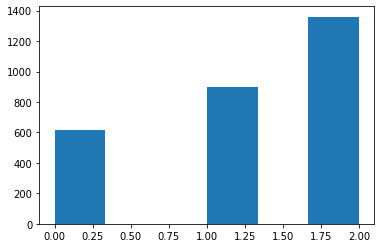

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

## Check that train and test have similar distribution.
plt.hist(y_test, bins=6, density=False)

In [72]:

## Set patterns to extract from tweets
keywords_dict = {"hcq":"ydroxych| hcq |plaqu |plaquenil|hydroquin|axemal",
                "ivermectin": "ivermectin|stromectol|soolantra|sklice",
                "remdesivir": "remdesivir|veklury",
                "molnupiravir": "molnupiravir|merck's drug|merck's pill|merck's antiviral"}

tobe_masked = [ i.strip() for i in keywords_dict["hcq"].split("|")]

def mask(x):
    for w in tobe_masked:
        if w in x:
            return "[mask]"
    return x

def m(sent):
    new_sent = []
    sent = sent.lower().split(" ")
    for word in sent:
        new_sent.append(mask(word))
    return " ".join(new_sent)

X_train_df = pd.DataFrame(X_test)
masked = X_train_df[0].parallel_apply(lambda x: m(x)).tolist()

In [49]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# MODEL = "rabindralamsal/finetuned-bertweet-sentiment-analysis"
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at /mnt/hdd/ningh/.cache/huggingface/transformers/7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "tweeteval_new/roberta-base-rt-sentiment/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer

In [74]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True,return_tensors = 'pt')
# dev_encodings = tokenizer(X_dev, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(masked, truncation=True, padding=True,return_tensors = 'pt')

In [75]:
len(X_train)

11492

In [76]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    ## Test Dataset
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [77]:
train_dataset = SentimentDataset(train_encodings, y_train)
dev_dataset = SentimentDataset(dev_encodings, y_test)
test_dataset = SentimentDataset(test_encodings, y_test)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(test_dataset, batch_size=8)



In [56]:

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)


loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at /mnt/hdd/ningh/.cache/huggingface/transformers/7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "tweeteval_new/roberta-base-rt-sentiment/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attent

In [57]:
# batch_size = 8
# import numpy as np
# from datasets import load_metric

# metric = load_metric("recall")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

# from transformers import TrainingArguments
# args = TrainingArguments(
#     f"drug-stance-bert",
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     # push_to_hub=True,
# )


In [58]:
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_dataset,
#     eval_dataset=dev_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics)

# torch.cuda.empty_cache()
# trainer.train()

In [59]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [60]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [61]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [62]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  0%|          | 0/4311 [00:00<?, ?it/s]

<ipython-input-54-15798f005e27>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [78]:
from datasets import load_metric

metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to("cuda:1") for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

<ipython-input-76-15798f005e27>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'accuracy': 0.8350156630699617}

In [79]:
# model.push_to_hub("drug-stance-bert", organization="MTERMS")
model.save_pretrained("model/Twitter-drug-stance-bert-masked")

/mnt/enchome/anaconda3/envs/twee/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Configuration saved in model/Twitter-drug-stance-bert-masked/config.json
Model weights saved in model/Twitter-drug-stance-bert-masked/pytorch_model.bin
